In [5]:
import os
from glob import glob
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.swa_utils import update_bn

import torchvision.transforms as T
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10

from tqdm.notebook import tqdm, trange

mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]
input_size = 32

test_transform  = T.Compose([
    T.ToTensor(), 
    T.Normalize(mean, std)
])

# test_set = CIFAR10("/opt/datasets/cifar10", train=False, download=True, transform=test_transform)
# test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


def create_model() -> nn.Module:
    model = resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    model.maxpool = nn.Identity()
    return model


def load_model_from_checkpoint(ckpt: str) -> nn.Module:
    model = create_model()
    checkpoint = torch.load(ckpt, map_location='cpu')
    state_dict = checkpoint['state_dict']
    msg = model.load_state_dict(state_dict, strict=True)
    print(msg)
    return model


@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Dict[str, torch.Tensor]:
    
    # Update BNs from dataloader.
    update_bn(dataloader, model, device)

    all_targets = []
    all_logits = []
    
    model.eval()
    for imgs, lbls in dataloader:
        if device is not None:
            imgs, lbls = imgs.to(device), lbls.to(device)
        logits = model(imgs)
        all_targets.append(lbls)
        all_logits.append(logits)
    
    all_targets = torch.cat(all_targets, dim=0)
    all_logits  = torch.cat(all_logits, dim=0)

    return {
        "logits": all_logits,
        "targets": all_targets
    }

In [6]:
TRAIN_SIZE = 2000

checkpoints = []

# EXP_DIR = './empirical/ensemble_20220923_163947/'
# checkpoints = glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
# print(f"Found {len(checkpoints)} checkpoints.")

# EXP_DIR = './empirical/ensemble_20220922_*/'
# checkpoints += glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
# print(f"Found {len(checkpoints)} checkpoints.")

EXP_DIR = './empirical/swa_20220922_185019/'
checkpoints += glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
print(f"Found {len(checkpoints)} checkpoints.")

models = [load_model_from_checkpoint(ckpt) for ckpt in checkpoints]

Found 0 checkpoints.


In [3]:
gather_all_weights = []

for model in models:
    all_weights = []
    for n, p in model.named_parameters():
        if "bn" not in n:
            all_weights.append(p.data.flatten().numpy())
    all_weights = np.hstack(all_weights)
    gather_all_weights.append(all_weights)

gather_all_weights = np.vstack(gather_all_weights)
gather_all_weights.shape

(5, 11166154)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fitted_weight_space = pca.fit_transform(gather_all_weights)

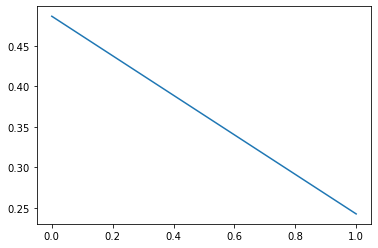

In [5]:
plt.plot(pca.explained_variance_ratio_)

In [6]:
maxs = fitted_weight_space.max(axis=0)
mins = fitted_weight_space.min(axis=0)

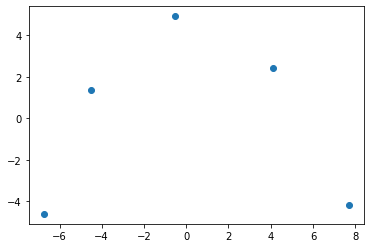

In [7]:
plt.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1])

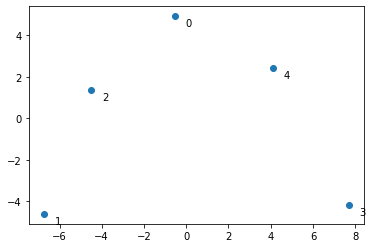

In [8]:
plt.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1])
for i in range(len(fitted_weight_space)):
    plt.text(fitted_weight_space[i, 0]+0.5, fitted_weight_space[i, 1]-0.5, s=str(i))

In [9]:
maxs = fitted_weight_space.max(axis=0)
mins = fitted_weight_space.min(axis=0)

xs = np.linspace(mins[0]-2, maxs[0]+2, 31)
ys = np.linspace(mins[1]-2, maxs[1]+2, 31)
x_grid, y_grid = np.meshgrid(xs, ys)

In [10]:
device = torch.device('cuda')

nlls = np.zeros((len(xs), len(ys)))
accs = np.zeros((len(xs), len(ys)))

for i in range(len(xs)):

    for j in range(len(ys)):

        x_pt, y_pt = xs[i], ys[j]
        pt_at_grid = np.array([x_pt, y_pt])
        transformed_weights = pca.inverse_transform(pt_at_grid)
        
        weight_idx = 0
        model = create_model()

        for n, p in model.named_parameters():
            if "bn" not in n:
                shape = p.data.shape
                numel = p.data.numel()

                weight_copy = transformed_weights[weight_idx:weight_idx+numel].copy()
                weight_copy = weight_copy.reshape(shape)
                weight_copy = torch.tensor(weight_copy, dtype=p.dtype)
                p.data.copy_(weight_copy)
                
                weight_idx += numel
            
        model.to(device)
        eval_results = evaluate(model, test_loader, device)
        logits = eval_results['logits'].cpu()
        targets = eval_results['targets'].cpu()
        preds = torch.argmax(logits, dim=1)

        nll = F.cross_entropy(logits, targets)
        acc = (preds == targets).float().mean()
        nlls[i, j] = nll.item()
        accs[i, j] = acc.item()

        print(f"{acc:.3f}", end=' ')
        
    print()

0.426 0.432 0.439 0.444 0.449 0.454 0.459 0.463 0.467 0.468 0.468 0.468 0.468 0.470 0.469 0.468 0.467 0.463 0.461 0.456 0.451 0.447 0.442 0.440 0.432 0.425 0.419 0.411 0.403 0.395 0.387 
0.435 0.442 0.447 0.453 0.457 0.463 0.468 0.472 0.474 0.476 0.478 0.478 0.478 0.477 0.476 0.474 0.472 0.472 0.467 0.465 0.461 0.459 0.453 0.447 0.441 0.434 0.425 0.419 0.410 0.402 0.395 
0.443 0.451 0.456 0.464 0.468 0.474 0.476 0.480 0.482 0.485 0.486 0.487 0.483 0.483 0.482 0.483 0.481 0.480 0.478 0.475 0.470 0.465 0.458 0.454 0.448 0.441 0.436 0.426 0.417 0.408 0.401 
0.450 0.457 0.465 0.469 0.475 0.482 0.485 0.488 0.492 0.494 0.494 0.494 0.495 0.493 0.491 0.490 0.490 0.490 0.489 0.483 0.477 0.472 0.466 0.461 0.455 0.448 0.441 0.434 0.424 0.415 0.408 
0.459 0.466 0.473 0.477 0.483 0.489 0.496 0.496 0.500 0.501 0.500 0.500 0.501 0.501 0.501 0.500 0.500 0.498 0.495 0.494 0.489 0.483 0.476 0.470 0.462 0.455 0.449 0.440 0.432 0.424 0.416 
0.470 0.475 0.483 0.488 0.494 0.500 0.504 0.506 0.506 0.507 0.510

In [2]:
accs = np.array([
    [0.426, 0.432, 0.439, 0.444, 0.449, 0.454, 0.459, 0.463, 0.467, 0.468, 0.468, 0.468, 0.468, 0.470, 0.469, 0.468, 0.467, 0.463, 0.461, 0.456, 0.451, 0.447, 0.442, 0.440, 0.432, 0.425, 0.419, 0.411, 0.403, 0.395, 0.387], 
    [0.435, 0.442, 0.447, 0.453, 0.457, 0.463, 0.468, 0.472, 0.474, 0.476, 0.478, 0.478, 0.478, 0.477, 0.476, 0.474, 0.472, 0.472, 0.467, 0.465, 0.461, 0.459, 0.453, 0.447, 0.441, 0.434, 0.425, 0.419, 0.410, 0.402, 0.395], 
    [0.443, 0.451, 0.456, 0.464, 0.468, 0.474, 0.476, 0.480, 0.482, 0.485, 0.486, 0.487, 0.483, 0.483, 0.482, 0.483, 0.481, 0.480, 0.478, 0.475, 0.470, 0.465, 0.458, 0.454, 0.448, 0.441, 0.436, 0.426, 0.417, 0.408, 0.401], 
    [0.450, 0.457, 0.465, 0.469, 0.475, 0.482, 0.485, 0.488, 0.492, 0.494, 0.494, 0.494, 0.495, 0.493, 0.491, 0.490, 0.490, 0.490, 0.489, 0.483, 0.477, 0.472, 0.466, 0.461, 0.455, 0.448, 0.441, 0.434, 0.424, 0.415, 0.408], 
    [0.459, 0.466, 0.473, 0.477, 0.483, 0.489, 0.496, 0.496, 0.500, 0.501, 0.500, 0.500, 0.501, 0.501, 0.501, 0.500, 0.500, 0.498, 0.495, 0.494, 0.489, 0.483, 0.476, 0.470, 0.462, 0.455, 0.449, 0.440, 0.432, 0.424, 0.416], 
    [0.470, 0.475, 0.483, 0.488, 0.494, 0.500, 0.504, 0.506, 0.506, 0.507, 0.510, 0.508, 0.508, 0.510, 0.508, 0.509, 0.508, 0.506, 0.504, 0.502, 0.495, 0.492, 0.485, 0.478, 0.472, 0.465, 0.457, 0.448, 0.441, 0.430, 0.424], 
    [0.479, 0.485, 0.492, 0.497, 0.502, 0.507, 0.511, 0.514, 0.515, 0.517, 0.519, 0.518, 0.519, 0.517, 0.516, 0.516, 0.513, 0.514, 0.512, 0.508, 0.503, 0.500, 0.496, 0.489, 0.481, 0.473, 0.466, 0.457, 0.448, 0.440, 0.430], 
    [0.486, 0.494, 0.501, 0.505, 0.510, 0.517, 0.521, 0.522, 0.524, 0.525, 0.526, 0.525, 0.525, 0.526, 0.524, 0.524, 0.521, 0.520, 0.517, 0.513, 0.511, 0.505, 0.499, 0.495, 0.488, 0.480, 0.471, 0.462, 0.454, 0.447, 0.436], 
    [0.492, 0.501, 0.508, 0.514, 0.520, 0.524, 0.528, 0.531, 0.533, 0.533, 0.535, 0.534, 0.532, 0.532, 0.530, 0.529, 0.527, 0.524, 0.524, 0.519, 0.515, 0.511, 0.507, 0.501, 0.495, 0.486, 0.477, 0.470, 0.460, 0.451, 0.443], 
    [0.499, 0.505, 0.512, 0.521, 0.523, 0.530, 0.534, 0.536, 0.537, 0.538, 0.540, 0.540, 0.538, 0.538, 0.537, 0.534, 0.533, 0.530, 0.529, 0.526, 0.521, 0.515, 0.510, 0.507, 0.499, 0.492, 0.485, 0.477, 0.467, 0.459, 0.450], 
    [0.504, 0.510, 0.517, 0.523, 0.529, 0.534, 0.536, 0.539, 0.539, 0.541, 0.543, 0.544, 0.544, 0.542, 0.542, 0.540, 0.537, 0.535, 0.533, 0.529, 0.525, 0.520, 0.515, 0.510, 0.503, 0.495, 0.487, 0.481, 0.472, 0.464, 0.457], 
    [0.508, 0.514, 0.520, 0.525, 0.531, 0.534, 0.537, 0.541, 0.542, 0.545, 0.546, 0.546, 0.548, 0.548, 0.547, 0.544, 0.541, 0.539, 0.536, 0.534, 0.527, 0.524, 0.518, 0.513, 0.507, 0.499, 0.492, 0.485, 0.477, 0.470, 0.461], 
    [0.509, 0.514, 0.521, 0.526, 0.531, 0.533, 0.538, 0.542, 0.544, 0.544, 0.546, 0.548, 0.548, 0.549, 0.548, 0.547, 0.544, 0.542, 0.539, 0.536, 0.531, 0.525, 0.520, 0.515, 0.508, 0.502, 0.494, 0.487, 0.477, 0.471, 0.464], 
    [0.507, 0.513, 0.521, 0.526, 0.531, 0.534, 0.538, 0.540, 0.544, 0.544, 0.546, 0.548, 0.549, 0.549, 0.549, 0.548, 0.546, 0.542, 0.539, 0.535, 0.533, 0.528, 0.521, 0.516, 0.509, 0.502, 0.495, 0.486, 0.478, 0.470, 0.464], 
    [0.507, 0.514, 0.519, 0.524, 0.530, 0.534, 0.538, 0.539, 0.542, 0.543, 0.544, 0.546, 0.548, 0.547, 0.549, 0.547, 0.545, 0.542, 0.538, 0.535, 0.531, 0.527, 0.522, 0.517, 0.510, 0.501, 0.495, 0.489, 0.481, 0.474, 0.465], 
    [0.507, 0.513, 0.517, 0.520, 0.527, 0.530, 0.533, 0.535, 0.538, 0.539, 0.541, 0.544, 0.544, 0.545, 0.545, 0.544, 0.542, 0.541, 0.539, 0.534, 0.532, 0.528, 0.524, 0.518, 0.512, 0.506, 0.499, 0.491, 0.484, 0.477, 0.469], 
    [0.507, 0.511, 0.515, 0.519, 0.522, 0.526, 0.529, 0.530, 0.533, 0.536, 0.537, 0.539, 0.539, 0.541, 0.542, 0.542, 0.540, 0.538, 0.536, 0.533, 0.529, 0.525, 0.521, 0.518, 0.513, 0.509, 0.502, 0.493, 0.486, 0.481, 0.471], 
    [0.503, 0.507, 0.512, 0.516, 0.520, 0.523, 0.524, 0.527, 0.531, 0.533, 0.535, 0.535, 0.536, 0.536, 0.538, 0.537, 0.536, 0.534, 0.532, 0.531, 0.529, 0.525, 0.523, 0.517, 0.513, 0.508, 0.503, 0.496, 0.488, 0.481, 0.474], 
    [0.499, 0.505, 0.509, 0.513, 0.515, 0.519, 0.521, 0.524, 0.526, 0.530, 0.532, 0.532, 0.532, 0.533, 0.533, 0.533, 0.532, 0.531, 0.530, 0.529, 0.528, 0.525, 0.523, 0.518, 0.512, 0.509, 0.502, 0.498, 0.490, 0.482, 0.473], 
    [0.496, 0.502, 0.506, 0.511, 0.514, 0.516, 0.520, 0.522, 0.524, 0.526, 0.527, 0.530, 0.530, 0.532, 0.531, 0.528, 0.529, 0.527, 0.528, 0.526, 0.525, 0.523, 0.520, 0.516, 0.511, 0.506, 0.502, 0.496, 0.488, 0.482, 0.476], 
    [0.495, 0.500, 0.502, 0.507, 0.511, 0.515, 0.517, 0.522, 0.522, 0.524, 0.524, 0.527, 0.527, 0.528, 0.528, 0.528, 0.527, 0.526, 0.525, 0.524, 0.522, 0.520, 0.516, 0.512, 0.508, 0.502, 0.499, 0.494, 0.490, 0.483, 0.477], 
    [0.495, 0.498, 0.502, 0.506, 0.509, 0.514, 0.517, 0.517, 0.518, 0.522, 0.522, 0.523, 0.524, 0.526, 0.526, 0.526, 0.524, 0.525, 0.522, 0.521, 0.520, 0.516, 0.514, 0.511, 0.506, 0.502, 0.497, 0.492, 0.488, 0.485, 0.476], 
    [0.494, 0.498, 0.501, 0.506, 0.510, 0.512, 0.514, 0.516, 0.517, 0.519, 0.519, 0.519, 0.520, 0.522, 0.522, 0.523, 0.521, 0.519, 0.519, 0.518, 0.518, 0.515, 0.511, 0.509, 0.504, 0.499, 0.496, 0.492, 0.486, 0.483, 0.477], 
    [0.492, 0.496, 0.500, 0.504, 0.507, 0.510, 0.513, 0.514, 0.515, 0.515, 0.516, 0.517, 0.519, 0.518, 0.518, 0.518, 0.517, 0.516, 0.515, 0.515, 0.514, 0.512, 0.511, 0.508, 0.502, 0.497, 0.494, 0.489, 0.484, 0.481, 0.478], 
    [0.488, 0.492, 0.498, 0.502, 0.504, 0.507, 0.510, 0.511, 0.512, 0.513, 0.514, 0.516, 0.516, 0.515, 0.515, 0.514, 0.513, 0.513, 0.513, 0.511, 0.510, 0.510, 0.508, 0.506, 0.502, 0.496, 0.493, 0.488, 0.484, 0.479, 0.474], 
    [0.485, 0.490, 0.495, 0.498, 0.503, 0.505, 0.506, 0.509, 0.510, 0.511, 0.511, 0.511, 0.512, 0.512, 0.510, 0.512, 0.510, 0.508, 0.507, 0.507, 0.505, 0.504, 0.503, 0.501, 0.499, 0.494, 0.490, 0.488, 0.484, 0.480, 0.475], 
    [0.482, 0.486, 0.491, 0.495, 0.498, 0.500, 0.503, 0.506, 0.507, 0.509, 0.509, 0.507, 0.508, 0.508, 0.506, 0.506, 0.507, 0.507, 0.504, 0.503, 0.502, 0.500, 0.498, 0.498, 0.496, 0.493, 0.488, 0.485, 0.483, 0.479, 0.474], 
    [0.478, 0.482, 0.488, 0.491, 0.494, 0.497, 0.500, 0.501, 0.503, 0.504, 0.504, 0.505, 0.503, 0.503, 0.503, 0.504, 0.505, 0.502, 0.501, 0.500, 0.498, 0.496, 0.494, 0.493, 0.491, 0.489, 0.486, 0.482, 0.480, 0.478, 0.474], 
    [0.477, 0.480, 0.484, 0.488, 0.490, 0.493, 0.496, 0.498, 0.498, 0.500, 0.500, 0.500, 0.500, 0.499, 0.499, 0.500, 0.500, 0.498, 0.498, 0.497, 0.495, 0.494, 0.491, 0.490, 0.488, 0.487, 0.483, 0.480, 0.479, 0.475, 0.472], 
    [0.475, 0.478, 0.481, 0.485, 0.488, 0.489, 0.491, 0.493, 0.493, 0.495, 0.495, 0.495, 0.496, 0.495, 0.496, 0.496, 0.495, 0.495, 0.496, 0.495, 0.493, 0.491, 0.488, 0.489, 0.486, 0.485, 0.481, 0.477, 0.475, 0.471, 0.468], 
    [0.472, 0.476, 0.479, 0.480, 0.484, 0.486, 0.488, 0.490, 0.490, 0.490, 0.491, 0.490, 0.491, 0.491, 0.491, 0.491, 0.491, 0.493, 0.493, 0.491, 0.490, 0.488, 0.486, 0.484, 0.483, 0.482, 0.479, 0.476, 0.472, 0.466, 0.465], 
])

NameError: name 'np' is not defined

In [1]:
import matplotlib.patches as patches

ARROW_STYLE = "Simple, tail_width=0.5, head_width=8, head_length=8"

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(6, 5))

cbar = ax.contourf(x_grid, y_grid, accs, levels=10)
ax.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1], c='white', marker='x', s=64)
for i in range(len(fitted_weight_space)):
    ax.text(fitted_weight_space[i, 0]+0.5, fitted_weight_space[i, 1]-0.5, s=str(i))
    if (i > 0 and i <= 4) or (i > 5 and i <= 9):
        x_prev, y_prev = fitted_weight_space[i-1, 0], fitted_weight_space[i-1, 1]
        x_curr, y_curr = fitted_weight_space[i, 0], fitted_weight_space[i, 1]
        arr = patches.FancyArrowPatch((x_prev, y_prev), (x_curr, y_curr), arrowstyle=ARROW_STYLE, connectionstyle="arc3, rad=.2")
        fig.gca().add_patch(arr)
    
ax.axis('off')
fig.colorbar(cbar)
fig.show()

NameError: name 'plt' is not defined